# Задание 3. Используй модель решающего дерева для скоринга и визуализируй своё дерево решений

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import tree
import graphviz
import pydotplus

### Необходимо:
* Разделить датасет на обучающую и тестовую выборки в соотношении 80:20 с использованием train_test_split.
* Используя обучающую выборку датасета, обучить модель, которая будет использоваться для оценки вероятности дефолта заемщика в процессе жизни кредита. Акцентируй внимание на том, какие гиперпараметры были подобраны для модели.
* Проверить работу модели с использованием тестовой выборки:
 - Посмотреть метрику ROC AUC на обучающей и тестовой выборках. Сильно ли меняется её качество?
 - Какие признаки получились наиболее важными (feature importance)?
 - Можно ли объяснить именно такое распределение признаков по важности?
* Визуализировать дерево в Jupyter. 

Hints:

- Для построения модели используй библиотеку Scikit-learn.
- Для отображения дерева в блокноте Jupyter используй функцию export_graphviz Scikit-learn, но если хочешь, то можно использовать и другие. Для построения дерева также необходимо установить graphviz и pydotplus.

**Дополнительные сведения:**  В таблице содержится информация о сумме предоставленного кредита (*LIMIT_BAL*) и возрасте заемщика (*AGE*), о его поле (*SEX*: 1 = мужской; 2 = женский), образовании (*EDUCATION*: 1 = аспирантура, 2 = университет, 3 = средняя школа, 4 = другое, 5 = нет образования, 6 = не хочу отвечать) и семейном положении (*MARRIAGE*: 1 = женат, 2 = холост, 3 = другое). Первая строка таблицы - истинные названия столбцов (по заданию)

In [2]:
# полностью выводить DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

**Т.к. вся предобработка данных была описана в задании 2, то сейчас сразу выполним все действия в одной ячейке без пояснений. Неизвестные значения в MARRIAGE и EDUCATION (помечены меткой 0) не будем удалять**

In [3]:
df = pd.read_csv('default_of_credit_card_clients.xlsx - Data.csv')
df.columns = df.iloc[0]
df = df.drop(labels=0, axis=0)
df = df.rename({'default payment next month': 'default_payment_next_month'}, axis=1)
df = df.apply(pd.to_numeric, errors='coerce', axis=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


*Т.к. образование и семейное положение были категориальными признаками, преобразуем их с помощью OHE|get_dummies(). Выведем heatmap для просмотра корреляции  (перед этим вынесем target в конец ля удобства)*

In [4]:
df = pd.get_dummies(df, columns=['EDUCATION', 'MARRIAGE'])
df = df[['ID', 'LIMIT_BAL', 'SEX', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
        'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
        'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 
        'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2',
        'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'MARRIAGE_0', 
        'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'default_payment_next_month']]
df.head(3)

,ID,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default_payment_next_month
1,1,20000,2,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,2,120000,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,0,1,0,0,0,0,0,0,1,0,1
3,3,90000,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,0,0,0,0,1,0,0


<AxesSubplot:>

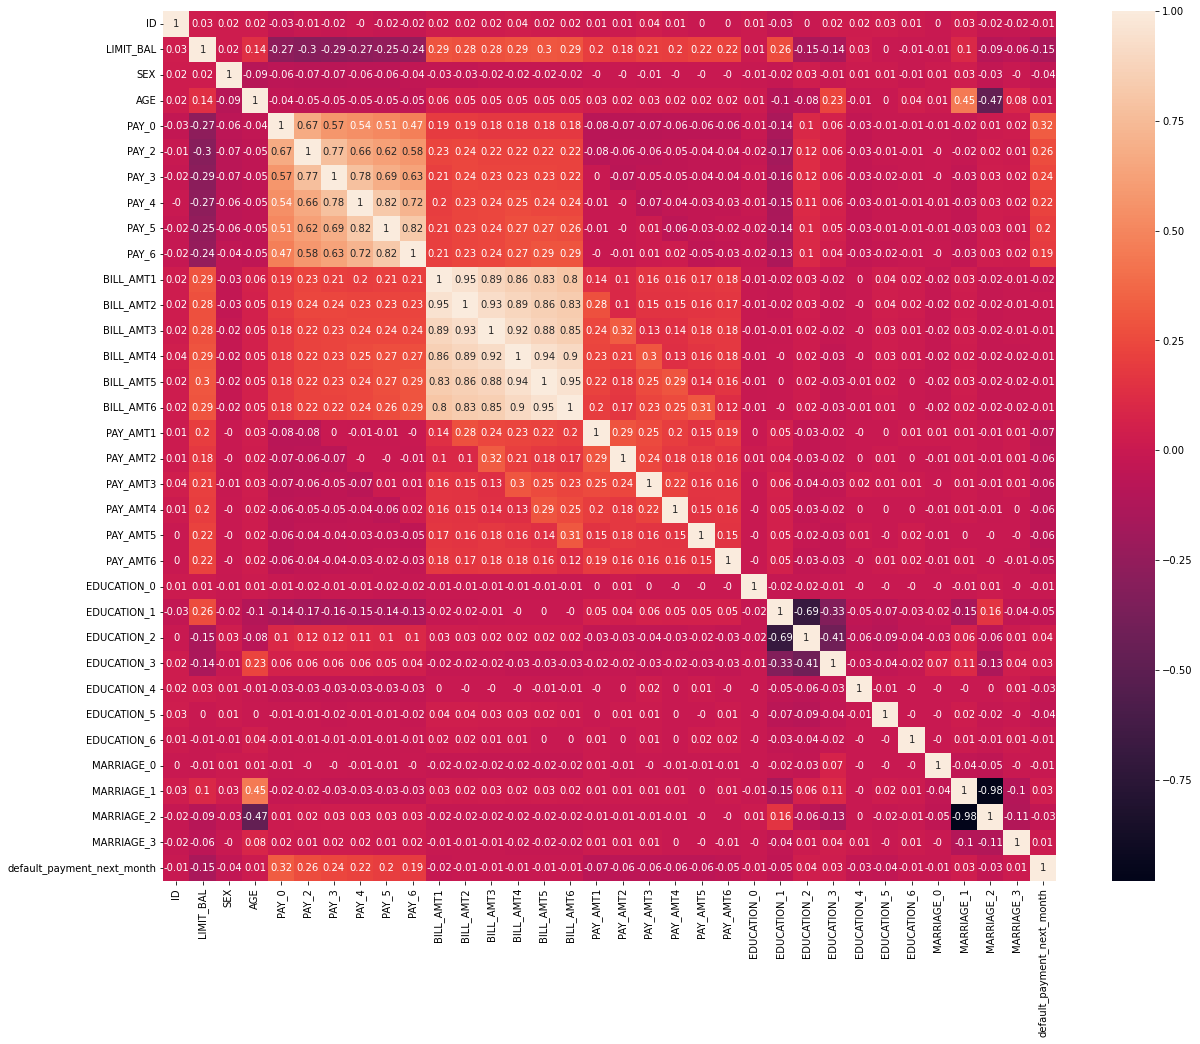

In [5]:
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr().round(2), annot=True,)

*Согласно заданию не требуется осуществлять отбор признаков (хотя и видно сразу по корреляции, что большинство признаков не уместны). Поэтому с помощью GridSearchCV* **подберем гиперпараметры модели**, *а затем* **разобьем на train/test (80:20)**

In [6]:
X = df.drop(['ID', 'default_payment_next_month'], axis=1)
y = df['default_payment_next_month']

In [7]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 6, 9, 12],
          'min_samples_split': [2, 4, 6, 8],
          'min_samples_leaf': [1, 5, 9, 14]}
tree = DecisionTreeClassifier()
gcv = GridSearchCV(tree, params, cv=5, n_jobs=-1, scoring='roc_auc')
gcv.fit(X, y)

gcv_df = pd.DataFrame(gcv.cv_results_)[['mean_test_score', 'rank_test_score', 'param_criterion', 'param_max_depth', 'param_min_samples_leaf', 
                                       'param_min_samples_split']].sort_values(by='rank_test_score')

In [8]:
gcv_df.head(3)

,mean_test_score,rank_test_score,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split
31,0.756949,1,gini,6,14,8
30,0.756821,2,gini,6,14,6
29,0.756797,3,gini,6,14,4


In [9]:
gcv.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 14,
 'min_samples_split': 8}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

*Теперь создадим модель с подобранными гиперпараметрами и* **сравним ее метрику на train и test**

In [11]:
model = DecisionTreeClassifier(criterion='gini', 
                               max_depth=6, 
                               min_samples_leaf=14,
                               min_samples_split=8)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=14, min_samples_split=8)

In [12]:
y_pred_train = model.predict(X_train)
train_pred = model.predict_proba(X_train)[:, 1]
test_pred = model.predict_proba(X_test)[:, 1]

print('score_train:', roc_auc_score(y_train, train_pred))
print('score_test:', roc_auc_score(y_test, test_pred))

score_train: 0.7707336816468128
score_test: 0.7625231488354067


*Построим ROC-кривую, чтобы визуализировать разницу между тесто и трейном модели*

In [13]:
# функция для удобства передачи параметров в график
def get_auc_curve(y_true, y_pred):
    auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    return auc_score, fpr, tpr

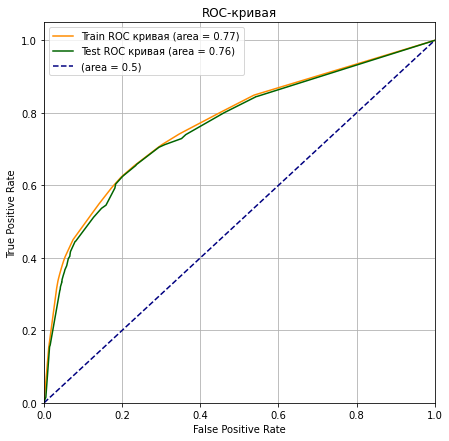

In [14]:
plt.figure(figsize=(7, 7))

roc_auc, fpr, tpr = get_auc_curve(y_train, train_pred)
plt.plot(fpr, tpr, color='darkorange',
         label='Train ROC кривая (area = %0.2f)' % roc_auc)

roc_auc, fpr, tpr = get_auc_curve(y_test, test_pred)
plt.plot(fpr, tpr, color='darkgreen',
         label='Test ROC кривая (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='(area = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid()
plt.show()

***ROC_AUC на train и test не сильно отличается***


*Выведем **model.feature_importances_** предварительно отсортировав по убыванию важности*

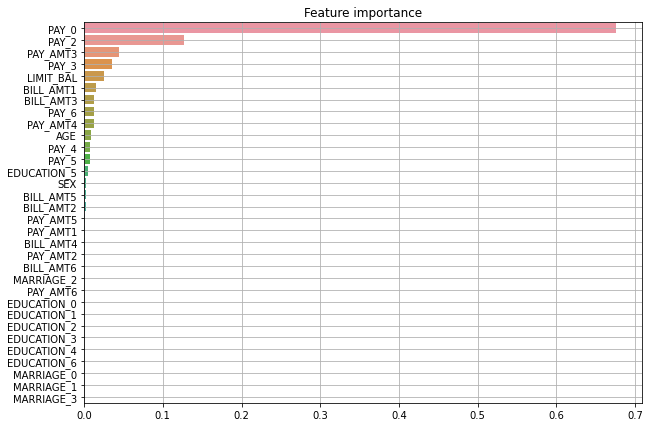

In [15]:
order = model.feature_importances_.argsort()[::-1]

plt.figure(figsize=(10, 7))
sns.barplot(x=model.feature_importances_[order], y=X.columns[order], orient='h')
plt.title('Feature importance')
plt.grid()
plt.show()

***Объяснение важности призаков***

*Пол, образование и семейное положение (как и ожидалось) не влияют на возращаемость кредитов. Сильно влияет состояние первых платежей по кредиту, т.к. ненадежный заемщик изначально будет платить не своевременно. Так же возвращаемость долга зависит и от суммы занятого, т.к. меньшую сумму проще вернуть*

***Визуализируем модель дерева решений***

Приведем два варианта:
* первый

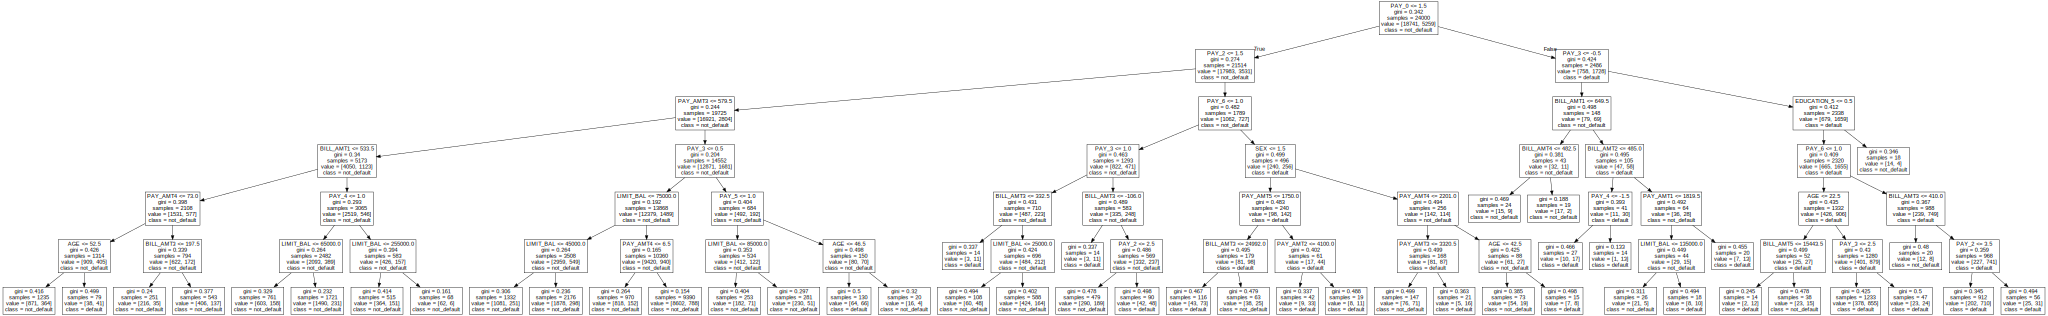

In [16]:
from IPython.display import display
display(graphviz.Source(export_graphviz(model, feature_names=X.columns, class_names=['not_default', 'default'])))

* второй

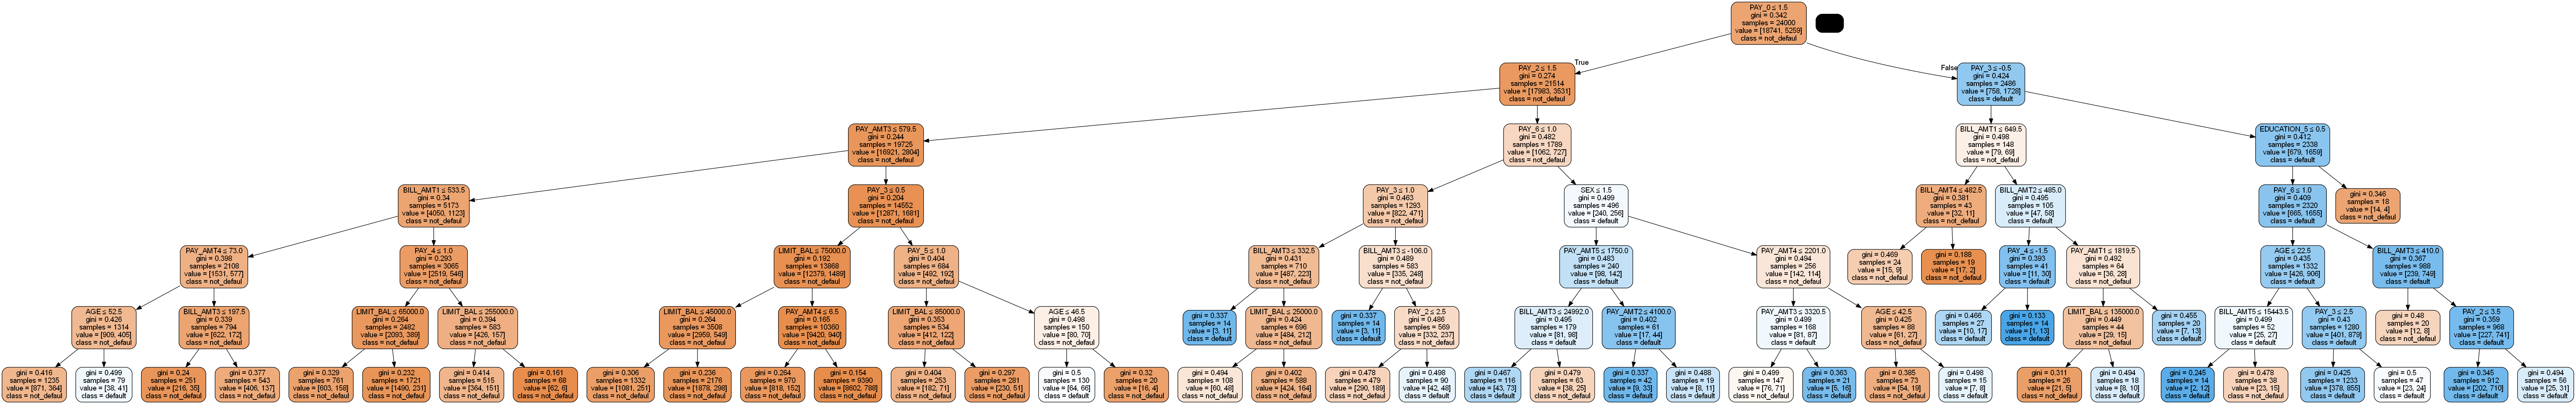

In [17]:
from sklearn.tree import export_graphviz
from six import StringIO 
from IPython.display import Image  
import pydotplus
feature_cols = list(X.columns)
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols ,class_names=['not_defaul','default'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree.png')
Image(graph.create_png())

## Исходя из матрицы корреляций и важности признаков делаем вывод, что модель еще можно улучшить и упростить. 

## Но т.к. задание было полностью выполнено, то упрощением и улучшением модели займемся позже